In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import psycopg2
import datetime

# Загрузка данных

In [2]:
df = pd.read_csv('sample_4400000_stratified.csv', sep=';')

In [3]:
# !!!
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [4]:
# !!!
df = df.drop('action', axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4384547 entries, 0 to 4384546
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   user_id    int64         
 2   post_id    int64         
 3   target     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 133.8 MB


In [6]:
df_users = pd.read_csv('users.csv', sep=';')
df_posts = pd.read_csv('posts.csv', sep=';')

In [7]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163205 entries, 0 to 163204
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    163205 non-null  int64 
 1   gender     163205 non-null  int64 
 2   age        163205 non-null  int64 
 3   country    163205 non-null  object
 4   city       163205 non-null  object
 5   exp_group  163205 non-null  int64 
 6   os         163205 non-null  object
 7   source     163205 non-null  object
dtypes: int64(4), object(4)
memory usage: 10.0+ MB


In [8]:
df_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   post_id  7023 non-null   int64 
 1   text     7023 non-null   object
 2   topic    7023 non-null   object
dtypes: int64(1), object(2)
memory usage: 164.7+ KB


## Обработка текста

In [ ]:
# !pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\apple\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\apple\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

1. предобработка текста

In [12]:
import re
import string

from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer

wnl = WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", ' ', line)
    line = re.sub("(\\n|\\t)", ' ', line)
    line = re.sub("[^a-zA-Z ]", ' ', line)
    line = re.sub("( {2,})", ' ', line)
    line = line.lower()
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])

    return line


tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

2. tf-idf постов

In [13]:
tfidf_data = tfidf.fit_transform(df_posts['text']).toarray()

tfidf_data

C:\Users\apple\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  warnings.warn(


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
tfidf_data.shape

(7023, 42044)

3. статистики по tf-idf (суммарный, максимальный, средний)

In [15]:
df_posts['total_tfidf'] = np.sum(tfidf_data, axis=1).reshape(-1,1)
df_posts['max_tfidf'] = np.max(tfidf_data, axis=1).reshape(-1,1)
df_posts['mean_tfidf'] = np.mean(tfidf_data, axis=1).reshape(-1,1)

In [16]:
df_posts

,post_id,text,topic,total_tfidf,max_tfidf,mean_tfidf
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.451976,0.504114,0.000201
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.514097,0.317233,0.000274
2,3,Asian quake hits European shares\n\nShares in ...,business,12.190354,0.269016,0.000290
3,4,India power shares jump on debut\n\nShares in ...,business,6.416335,0.541172,0.000153
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.205266,0.422695,0.000148
...,...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,6.638942,0.259546,0.000158
7019,7316,I give this movie 2 stars purely because of it...,movie,6.471390,0.399528,0.000154
7020,7317,I cant believe this film was allowed to be mad...,movie,5.508128,0.576569,0.000131
7021,7318,The version I saw of this film was the Blockbu...,movie,6.883273,0.231254,0.000164


4. выделение PCA компонент из tf-idf

In [17]:
from sklearn.decomposition import PCA

centered = tfidf_data - tfidf_data.mean()

pca = PCA(n_components=10)
pca_decomp = pca.fit_transform(centered)

In [18]:
pca_decomp.shape

(7023, 10)

In [19]:
pca.singular_values_

array([8.62912658, 7.27603288, 5.73827478, 5.36985124, 4.8887587 ,
       4.60359714, 4.49897377, 4.17985294, 4.13428407, 3.90447989])

5. выделение кластеров, расстояние до центров кластеров как признаки постов

In [20]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0).fit(pca_decomp)

In [21]:
dists_columns = [f"dist_{ith}_cluster" for ith in range(1, 11)]

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

df_posts = pd.concat((df_posts, dists_df), axis=1)
df_posts.head()

,post_id,text,topic,total_tfidf,max_tfidf,mean_tfidf,dist_1_cluster,dist_2_cluster,dist_3_cluster,dist_4_cluster,dist_5_cluster,dist_6_cluster,dist_7_cluster,dist_8_cluster,dist_9_cluster,dist_10_cluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.451976,0.504114,0.000201,0.529202,0.360233,0.405338,0.432061,0.376172,0.435858,0.164315,0.396622,0.440188,0.373812
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.514097,0.317233,0.000274,0.455404,0.228091,0.310330,0.343591,0.258377,0.331772,0.172281,0.307820,0.178206,0.288354
2,3,Asian quake hits European shares\n\nShares in ...,business,12.190354,0.269016,0.000290,0.483669,0.282794,0.343528,0.370887,0.313606,0.391628,0.091825,0.346137,0.422754,0.328743
3,4,India power shares jump on debut\n\nShares in ...,business,6.416335,0.541172,0.000153,0.414916,0.234871,0.315407,0.345934,0.269711,0.356699,0.066455,0.302634,0.372526,0.312198
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.205266,0.422695,0.000148,0.396542,0.085679,0.225332,0.265025,0.206087,0.281659,0.163673,0.213995,0.318449,0.219910


In [22]:
df_posts.to_csv('posts_feats.csv', sep=';', index=False)

In [9]:
df_posts = pd.read_csv('posts_feats.csv', sep=';')

загрузка признаков в БД

In [ ]:
df_posts.to_sql(    
   "posts_features_0",                    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml",                      
    schema="public",                   
    if_exists='replace'            
   )

загрузка признаков из БД

In [10]:
df_posts = pd.read_sql(
    """SELECT * FROM public.posts_features_0""",
    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
).drop(['index'], axis=1)

OperationalError: (psycopg2.OperationalError) connection to server at "postgres.lab.karpov.courses" (116.203.248.181), port 6432 failed: ERROR:  pgbouncer cannot connect to server

(Background on this error at: https://sqlalche.me/e/14/e3q8)

6. объединение признаков постов, текстов и пользователей

In [10]:
df = pd.merge(df,
              df_posts,
              on='post_id',
              how='left')

df.head()

,timestamp,user_id,post_id,target,text,topic,total_tfidf,max_tfidf,mean_tfidf,dist_1_cluster,dist_2_cluster,dist_3_cluster,dist_4_cluster,dist_5_cluster,dist_6_cluster,dist_7_cluster,dist_8_cluster,dist_9_cluster,dist_10_cluster
0,2021-12-24 13:59:16,200,6450,0,One of the joys of picking up the recent Bela ...,movie,6.501989,0.336207,0.000155,0.443013,0.171766,0.220949,0.113467,0.308386,0.324533,0.301895,0.260958,0.402867,0.282926
1,2021-11-13 19:14:30,200,2428,0,BELIEVE IN YOURSELF\n#day123 #day123lockdown #...,covid,2.670926,0.456235,0.000064,0.351119,0.172480,0.265344,0.298750,0.313787,0.327637,0.290393,0.029247,0.387217,0.275524
2,2021-11-13 19:25:58,200,3269,0,"Remember, its the Eat Out to Help Out scheme M...",covid,3.031322,0.518291,0.000072,0.379742,0.060628,0.214046,0.252263,0.259727,0.298161,0.225936,0.172918,0.343751,0.214011
3,2021-10-02 14:34:03,200,2815,0,When ever a country is invaded or its citizens...,covid,2.867305,0.460035,0.000068,0.376644,0.075328,0.219484,0.262359,0.270043,0.301172,0.208625,0.176534,0.344052,0.221760
4,2021-11-13 19:28:29,200,3683,0,I hate it here.......I really do😏\n#Quarantine...,covid,1.860404,0.728474,0.000044,0.393078,0.312834,0.359666,0.378942,0.410284,0.437704,0.400592,0.137619,0.474781,0.381879


In [11]:
df = pd.merge(df,
              df_users,
              on='user_id',
              how='left')

df.head()

,timestamp,user_id,post_id,target,text,topic,total_tfidf,max_tfidf,mean_tfidf,dist_1_cluster,...,dist_8_cluster,dist_9_cluster,dist_10_cluster,gender,age,country,city,exp_group,os,source
0,2021-12-24 13:59:16,200,6450,0,One of the joys of picking up the recent Bela ...,movie,6.501989,0.336207,0.000155,0.443013,...,0.260958,0.402867,0.282926,1,34,Russia,Degtyarsk,3,Android,ads
1,2021-11-13 19:14:30,200,2428,0,BELIEVE IN YOURSELF\n#day123 #day123lockdown #...,covid,2.670926,0.456235,0.000064,0.351119,...,0.029247,0.387217,0.275524,1,34,Russia,Degtyarsk,3,Android,ads
2,2021-11-13 19:25:58,200,3269,0,"Remember, its the Eat Out to Help Out scheme M...",covid,3.031322,0.518291,0.000072,0.379742,...,0.172918,0.343751,0.214011,1,34,Russia,Degtyarsk,3,Android,ads
3,2021-10-02 14:34:03,200,2815,0,When ever a country is invaded or its citizens...,covid,2.867305,0.460035,0.000068,0.376644,...,0.176534,0.344052,0.221760,1,34,Russia,Degtyarsk,3,Android,ads
4,2021-11-13 19:28:29,200,3683,0,I hate it here.......I really do😏\n#Quarantine...,covid,1.860404,0.728474,0.000044,0.393078,...,0.137619,0.474781,0.381879,1,34,Russia,Degtyarsk,3,Android,ads


7. добавление признаков по времени

In [12]:
df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)
df['day'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.dayofweek)

df.head()

,timestamp,user_id,post_id,target,text,topic,total_tfidf,max_tfidf,mean_tfidf,dist_1_cluster,...,gender,age,country,city,exp_group,os,source,hour,month,day
0,2021-12-24 13:59:16,200,6450,0,One of the joys of picking up the recent Bela ...,movie,6.501989,0.336207,0.000155,0.443013,...,1,34,Russia,Degtyarsk,3,Android,ads,13,12,4
1,2021-11-13 19:14:30,200,2428,0,BELIEVE IN YOURSELF\n#day123 #day123lockdown #...,covid,2.670926,0.456235,0.000064,0.351119,...,1,34,Russia,Degtyarsk,3,Android,ads,19,11,5
2,2021-11-13 19:25:58,200,3269,0,"Remember, its the Eat Out to Help Out scheme M...",covid,3.031322,0.518291,0.000072,0.379742,...,1,34,Russia,Degtyarsk,3,Android,ads,19,11,5
3,2021-10-02 14:34:03,200,2815,0,When ever a country is invaded or its citizens...,covid,2.867305,0.460035,0.000068,0.376644,...,1,34,Russia,Degtyarsk,3,Android,ads,14,10,5
4,2021-11-13 19:28:29,200,3683,0,I hate it here.......I really do😏\n#Quarantine...,covid,1.860404,0.728474,0.000044,0.393078,...,1,34,Russia,Degtyarsk,3,Android,ads,19,11,5


In [13]:
df = df.drop('text', axis=1)
df.head()

,timestamp,user_id,post_id,target,topic,total_tfidf,max_tfidf,mean_tfidf,dist_1_cluster,dist_2_cluster,...,gender,age,country,city,exp_group,os,source,hour,month,day
0,2021-12-24 13:59:16,200,6450,0,movie,6.501989,0.336207,0.000155,0.443013,0.171766,...,1,34,Russia,Degtyarsk,3,Android,ads,13,12,4
1,2021-11-13 19:14:30,200,2428,0,covid,2.670926,0.456235,0.000064,0.351119,0.172480,...,1,34,Russia,Degtyarsk,3,Android,ads,19,11,5
2,2021-11-13 19:25:58,200,3269,0,covid,3.031322,0.518291,0.000072,0.379742,0.060628,...,1,34,Russia,Degtyarsk,3,Android,ads,19,11,5
3,2021-10-02 14:34:03,200,2815,0,covid,2.867305,0.460035,0.000068,0.376644,0.075328,...,1,34,Russia,Degtyarsk,3,Android,ads,14,10,5
4,2021-11-13 19:28:29,200,3683,0,covid,1.860404,0.728474,0.000044,0.393078,0.312834,...,1,34,Russia,Degtyarsk,3,Android,ads,19,11,5


# кодирование, создание DataLoader'а

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [15]:
# !pip install category_encoders

класс OHE который возвращает pandas.DataFrame

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

class OHE(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ohe = OneHotEncoder(categories='auto',
                                 drop='first',
                                 dtype=np.uint8,
                                 sparse=False)

    def fit(self, X, y=None):
        self.ohe.fit(X)
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_ = self.ohe.transform(X_)
        n_feats = self.ohe.n_features_in_
        feats = self.ohe.feature_names_in_
        cats = self.ohe.categories_

        columns = []
        for i in range(n_feats):
            main_cat = feats[i]
            cat_names = [f'{main_cat}_{name}' for name in cats[i][1:]]
            columns.extend(cat_names)
        
        df = pd.DataFrame(data=X_, columns=columns)
        return df

MinMaxScaler с заданием минимума и максимума

In [17]:
def minmax_scler(X_, X_min, X_max):
    X = X_.values 
    min, max = 0, 1
    X_std = (X - X_min) / (X_max - X_min)
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [23]:
df.columns

Index(['timestamp', 'user_id', 'post_id', 'target', 'topic', 'total_tfidf',
       'max_tfidf', 'mean_tfidf', 'dist_1_cluster', 'dist_2_cluster',
       'dist_3_cluster', 'dist_4_cluster', 'dist_5_cluster', 'dist_6_cluster',
       'dist_7_cluster', 'dist_8_cluster', 'dist_9_cluster', 'dist_10_cluster',
       'gender', 'age', 'country', 'city', 'exp_group', 'os', 'source', 'hour',
       'month', 'day'],
      dtype='object')

По количеству уникальных значений у разных признаков будем использовать разные экодеры:

- ['country', 'hour', 'city'] - MeanTarget кодирование
- ['topic', 'exp_group', 'day', 'month'] - OneHot кодирование
- ['gender', 'os', 'source'] - без кодирования
- ['total_tfidf', 'age'] - MinMax масштабирование

In [28]:
df[['topic', 'gender', 'age', 'country', 'city', 'exp_group', 'os', 'source']].apply(lambda x: x.nunique())

topic           7
gender          2
age            76
country        11
city         3915
exp_group       5
os              2
source          2
dtype: int64

In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import TargetEncoder

class DS(Dataset):
    def __init__(self, df: pd.DataFrame,
                 train: bool = True,
                 val: bool = False):

        self._train = train
        self._val = val

        self._user_ids = np.unique(df_users['user_id'])
        self._post_ids = np.unique(df_posts['post_id'])

        self.user2id = {v: k for k, v in enumerate(self._user_ids)}
        self.post2id = {v: k for k, v in enumerate(self._post_ids)}

        self.n_users = len(self.user2id)
        self.n_posts = len(self.post2id)


        df_train = df[(df['timestamp'] < '2021-12-10 00:00:00')]

        df_val = df[(df['timestamp'] >= '2021-12-10 00:00:00') \
                    & (df['timestamp'] < '2021-12-20 00:00:00')]

        df_test = df[(df['timestamp'] >= '2021-12-20 00:00:00')]

        # encoeders
        self._fit(df_train.drop('target', axis=1), df_train['target'])
        self._df_train = self._transform(df_train)
        self._df_val = self._transform(df_val)
        self._df_test = self._transform(df_test)


        if self._train and self._val:
            self.data = self._df_val # val
        elif self._train and not self._val:
            self.data = self._df_train # train
        else:
            self.data = self._df_test # test


    def __getitem__(self, index):
        row = self.data.iloc[index]
        user = self.user2id[row['user_id']]
        post = self.post2id[row['post_id']]
        label = row['target']
        feats = np.array(row[4:].values, dtype=np.float32)
        return user, post, feats, label

    
    def  __len__(self):
        return self.data.shape[0]

    
    def _fit(self, X, y):
        object_cols = [
          'topic', 'country', 'city', 'exp_group', 'os', 'source',
          'hour', 'month', 'day'
        ]

        self._cols_for_ohe = [x for x in object_cols if X[x].nunique() < 8]
        self._cols_for_mte = [x for x in object_cols if X[x].nunique() >= 8]
        self._scaler_cols = ['total_tfidf', 'age']

        self._encoder_ohe = OHE().fit(X[self._cols_for_ohe])
        self._encoder_mte = TargetEncoder(cols=self._cols_for_mte).fit(X[self._cols_for_mte], y)

        self._minmax_scaler = MinMaxScaler().fit(X[self._scaler_cols])


    def _transform(self, X):
        X_ = X.copy()
        X_ = X.drop(self._cols_for_ohe, axis=1).drop(self._cols_for_mte, axis=1)

        ohe = self._encoder_ohe.transform(X[self._cols_for_ohe]).set_index(X_.index)
        X_ = pd.concat([X_, ohe], axis=1)
        mte = self._encoder_mte.transform(X[self._cols_for_mte]).set_index(X_.index)
        X_ = pd.concat([X_, mte], axis=1)

        X_scaled = self._minmax_scaler.transform(X_[self._scaler_cols])
        for i, col in enumerate(self._scaler_cols):
            X_[col] = X_scaled[:, i]
        return X_

In [19]:
ds_train = DS(df, train=True, val=False)
ds_val = DS(df, train=False, val=True)
ds_test = DS(df, train=False, val=False)

C:\Users\apple\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\apple\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\apple\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\apple\anaconda3\lib\site-packages\category_encoders\target_enco

изначальные признаки

In [ ]:
df.columns

Index(['timestamp', 'user_id', 'post_id', 'target', 'topic', 'total_tfidf',
       'max_tfidf', 'mean_tfidf', 'dist_1_cluster', 'dist_2_cluster',
       'dist_3_cluster', 'dist_4_cluster', 'dist_5_cluster', 'dist_6_cluster',
       'dist_7_cluster', 'dist_8_cluster', 'dist_9_cluster', 'dist_10_cluster',
       'gender', 'age', 'country', 'city', 'exp_group', 'os', 'source', 'hour',
       'month', 'day'],
      dtype='object')

признаки после кодирования

In [20]:
ds_train.data.columns

Index(['timestamp', 'user_id', 'post_id', 'target', 'total_tfidf', 'max_tfidf',
       'mean_tfidf', 'dist_1_cluster', 'dist_2_cluster', 'dist_3_cluster',
       'dist_4_cluster', 'dist_5_cluster', 'dist_6_cluster', 'dist_7_cluster',
       'dist_8_cluster', 'dist_9_cluster', 'dist_10_cluster', 'gender', 'age',
       'topic_covid', 'topic_entertainment', 'topic_movie', 'topic_politics',
       'topic_sport', 'topic_tech', 'exp_group_1', 'exp_group_2',
       'exp_group_3', 'exp_group_4', 'os_iOS', 'source_organic', 'month_11',
       'month_12', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'country', 'city', 'hour'],
      dtype='object')

## сохранение данных для MeanTargetEncoding

In [ ]:
mte_country_enc = ds_train._encoder_mte.mapping['country'].reset_index().rename(columns={0: 'target_encoding'})
mte_country_cat = ds_train._encoder_mte.ordinal_encoder.mapping[0]['mapping'].reset_index().rename(columns={'index': 'country_name', 0: 'country'})
mte_country = pd.merge(mte_country_cat, mte_country_enc, on='country')[['country_name', 'target_encoding']]
mte_country_dict = {k: v for k, v in mte_country.values}
mte_country_dict

{'Russia': 0.10774984662537317,
 'Ukraine': 0.1704849812957921,
 'Belarus': 0.1844546919273293,
 'Azerbaijan': 0.08590941768511862,
 'Kazakhstan': 0.16265516638498748,
 'Finland': 0.13443072702331962,
 'Turkey': 0.2036526533425224,
 'Latvia': 0.16597077244258873,
 'Cyprus': 0.10802139037433155,
 'Switzerland': 0.08417508417508418,
 'Estonia': 0.12224448897795591,
 nan: 0.11460258364218187}

In [32]:
mte_city_enc = ds_train._encoder_mte.mapping['city'].reset_index().rename(columns={0: 'target_encoding'})
mte_city_cat = ds_train._encoder_mte.ordinal_encoder.mapping[1]['mapping'].reset_index().rename(columns={'index': 'city_name', 0: 'city'})
mte_city = pd.merge(mte_city_cat, mte_city_enc, on='city')[['city_name', 'target_encoding']]
mte_city_dict = {k: v for k, v in mte_city.values}
mte_city_dict

{'Degtyarsk': 0.10185185185185185,
 'Abakan': 0.133434420015163,
 'Smolensk': 0.14607218683651804,
 'Moscow': 0.1484223677480484,
 'Anzhero-Sudzhensk': 0.13114754098360656,
 'Dugulubgey': 0.04854368932038835,
 'Kamenka': 0.043137254901960784,
 'Groznyy': 0.0508816120906801,
 'Zima': 0.15298507462686567,
 'Yuzhnouralsk': 0.08609271523178808,
 'Mykolaiv': 0.15766738660907129,
 'Minsk': 0.14595660749506903,
 'Podolsk': 0.06568228105906314,
 'Kamianske': 0.22556390977443608,
 'Horodenka': 0.4817221910088523,
 'Lviv': 0.10286677908937605,
 'Kansk': 0.09602194787379972,
 'Novosibirsk': 0.06208425720620843,
 'Vologda': 0.13942534149788036,
 'Ulyanovsk': 0.10412844036697248,
 'Chernihiv': 0.19550561797752808,
 'Yekaterinburg': 0.07607768829938417,
 'Vilyuysk': 0.04411764705882353,
 'Saint Petersburg': 0.15233753842891976,
 'Baku': 0.0827503015681544,
 'Perm': 0.144292991876635,
 'Barnaul': 0.13989071038251366,
 'Kursk': 0.14664536741214057,
 'Volgograd': 0.13180968808394422,
 'Troitsk': 0.1494

In [ ]:
mte_city.to_sql(    
   "yaa_mte_city",                    
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml",                      
    schema="public",                   
    if_exists='replace'            
   ) 

In [24]:
# mte_city_df = pd.read_sql(
#     """SELECT * FROM public.yaa_mte_city""",
    
#     con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
#         "postgres.lab.karpov.courses:6432/startml"
# )

In [ ]:
mte_hour_enc = ds_train._encoder_mte.mapping['hour'].reset_index().rename(columns={0: 'target_encoding'})
mte_hour_cat = ds_train._encoder_mte.ordinal_encoder.mapping[2]['mapping'].reset_index().rename(columns={'index': 'hour_name', 0: 'hour'})
mte_hour = pd.merge(mte_hour_cat, mte_hour_enc, on='hour')[['hour_name', 'target_encoding']]
mte_hour_dict = {int(k): v for k, v in mte_hour[mte_hour['hour_name']>=0].values}
mte_hour_dict

{14: 0.10301614273576891,
 7: 0.11252939837645096,
 15: 0.10205006899270648,
 19: 0.12902374172622527,
 6: 0.1319546568627451,
 10: 0.10629228946060629,
 13: 0.10516573803003117,
 20: 0.14066699473823674,
 21: 0.14237058502530908,
 11: 0.10579090110393827,
 16: 0.10142239895996635,
 17: 0.10406214284330628,
 22: 0.1434022625219218,
 18: 0.1042717099960638,
 8: 0.11236259482892089,
 9: 0.10872183372183372,
 23: 0.10738048930289693,
 12: 0.10336711839957484,
 0: 0.11460258364218187}

In [ ]:
import json 

with open("mte_country_dict.json", "w") as outfile:
    json.dump(mte_country_dict, outfile)

with open("mte_city_dict.json", "w") as outfile:
    json.dump(mte_city_dict, outfile)

with open("mte_hour_dict.json", "w") as outfile:
    json.dump(mte_hour_dict, outfile)

min & max значения для `total_tfidf`

In [45]:
df[(df['timestamp'] < '2021-12-10 00:00:00')]['total_tfidf'].min(), df[(df['timestamp'] < '2021-12-10 00:00:00')]['total_tfidf'].max()

(0.0, 19.007281084946)

min & max значения для `age`

In [46]:
df[(df['timestamp'] < '2021-12-10 00:00:00')]['age'].min(), df[(df['timestamp'] < '2021-12-10 00:00:00')]['age'].max()

(14, 95)

# Сеть и обучение

In [31]:
BATCH_SIZE = 128

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

количество признаков:

In [31]:
ds_train[0][2].shape

(38,)

количество записей:

In [38]:
len(ds_train), len(ds_val), len(ds_test)

(3412483, 488760, 488760)

есть ли наны:

In [50]:
ds_train.data.isna().sum().sum(), ds_val.data.isna().sum().sum(), ds_test.data.isna().sum().sum()

(0, 0, 0)

инициализация весов эмбеддингов:

In [ ]:
def weights_init(module):
    if isinstance(module, nn.Embedding):
        in_feats = module.weight.shape[1]
        out_feats = module.weight.shape[0]
        n = np.mean([in_feats, out_feats])
        limit = np.sqrt(3 / n)

        module.weight.data.uniform_(-limit, limit)

класс NN:
- обучаемые эмбеддинги для  постов и пользователей размером 100
- два линейных слоя с ReLU нелинейностью

In [33]:
class NCCF(nn.Module):
    def __init__(self, n_users, n_items, latent_size, feats_size):
        super().__init__()
        
        self.latent_size = latent_size
        self.feats_size = feats_size
        self.n_users = n_users
        self.n_items = n_items

        self.embedding_user = nn.Embedding(self.n_users, latent_size)
        self.embedding_item = nn.Embedding(self.n_items, latent_size)

        self.lin1 = nn.Linear(latent_size*2 + feats_size, 64) # 238
        self.lin2 = nn.Linear(64, 1)
                                           
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        

    def forward(self, users, items, feats):
        emb_users = self.embedding_user(users)
        emb_items = self.embedding_item(items)
        x = torch.cat([emb_users, emb_items, feats], dim=1) # 100+100+38

        x = self.dropout(self.relu((self.lin1(x))))
        x = self.lin2(x)

        return x

In [26]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [ ]:
from tqdm import tqdm

def train(model):
    model.train()

    train_loss = 0
    total = 0


    for users, items, feats, labels in tqdm(dl_train, desc='Train'):
        users, items, feats, labels = users.to(DEVICE), items.to(DEVICE), \
                                      feats.to(DEVICE), \
                                      labels.type(torch.FloatTensor).to(DEVICE)
        optimizer.zero_grad()

        output = model(users, items, feats).type(torch.FloatTensor).to(DEVICE)

        loss = loss_fn(output.squeeze(), labels)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        

    train_loss /= len(dl_train)

    return train_loss

In [ ]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0
    total = 0

    for users, items, feats, labels in tqdm(loader, desc='Evaluation'):
        users, items, feats, labels = users.to(DEVICE), items.to(DEVICE), \
                                      feats.to(DEVICE), \
                                      labels.type(torch.FloatTensor).to(DEVICE)

        output = model(users, items, feats).type(torch.FloatTensor).to(DEVICE)

        loss = loss_fn(output.squeeze(), labels)

        total_loss += loss.item()


    total_loss /= len(dl_val)


    return total_loss

In [ ]:
def whole_train_valid_cycle(model, num_epochs):
    train_loss_history, valid_loss_history = [], []

    train_loss = evaluate(model, dl_train)
    min_valid = evaluate(model, dl_val)

    train_loss_history.append(train_loss)
    valid_loss_history.append(min_valid)

    for epoch in range(num_epochs):
        train_loss = train(model)
        valid_loss = evaluate(model, dl_val)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)


        if valid_loss < min_valid:
            loss = int(valid_loss*10**6)
            min_valid = valid_loss
            name = f'ncf_whole_02_{loss}'
            torch.save(model.state_dict(),
                       name)


        # visualize
        plt.figure(figsize=(10, 7))
        plt.plot(train_loss_history, label='Train loss')
        plt.plot(valid_loss_history, label='Valid loss')
        plt.legend()
        plt.grid()

        plt.show();



In [ ]:
n_users = ds_train.n_users
n_items = ds_train.n_posts
latent_size = 100
feats_size = ds_train[0][2].shape[0]

ncf = NCCF(n_users, n_items, latent_size, feats_size)
ncf.to(DEVICE)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(ncf.parameters(), lr=0.001)

Evaluation: 100%|██████████| 987/987 [00:35<00:00, 27.82it/s]


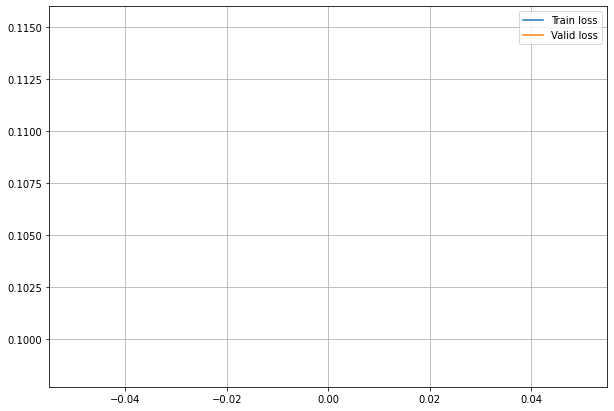

Evaluation: 100%|██████████| 987/987 [00:35<00:00, 27.66it/s]


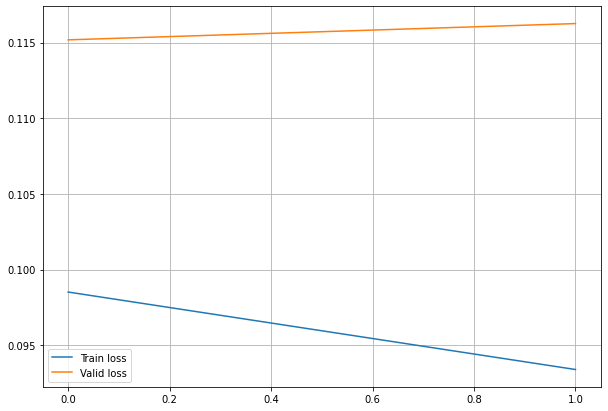

Evaluation: 100%|██████████| 987/987 [00:35<00:00, 27.62it/s]


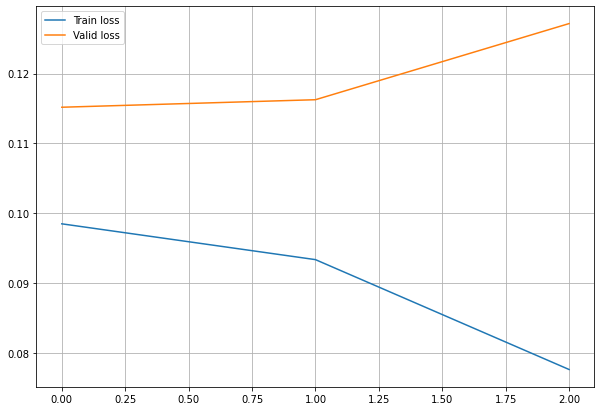

Evaluation: 100%|██████████| 987/987 [00:35<00:00, 27.61it/s]


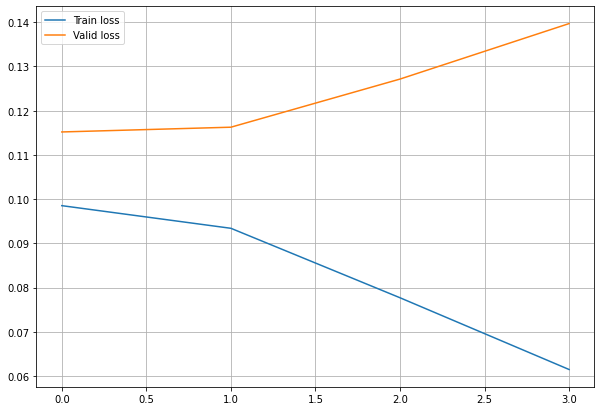

Evaluation: 100%|██████████| 987/987 [00:39<00:00, 25.15it/s]


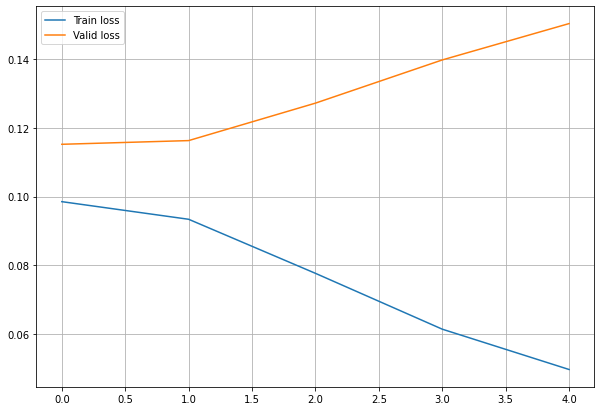

Evaluation: 100%|██████████| 987/987 [00:36<00:00, 26.74it/s]


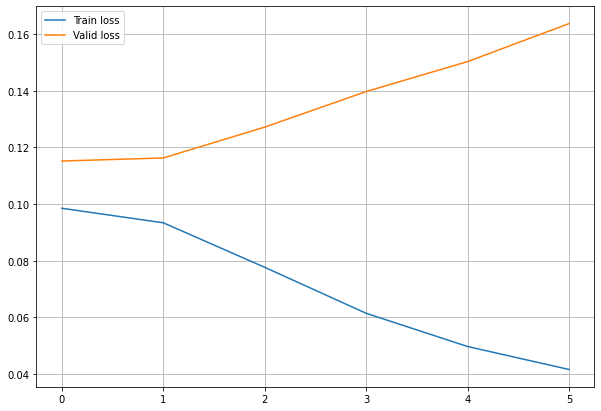

Evaluation: 100%|██████████| 987/987 [00:36<00:00, 26.74it/s]


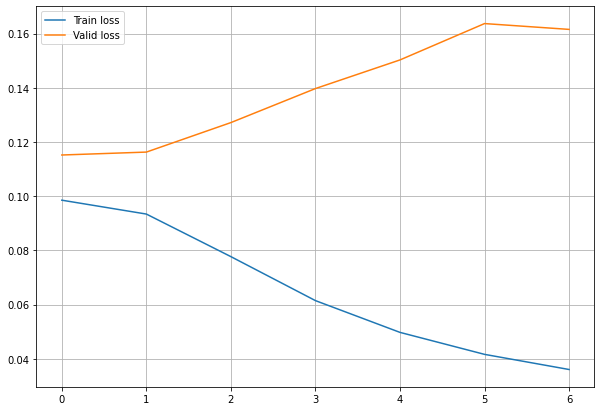

Evaluation: 100%|██████████| 987/987 [00:37<00:00, 26.19it/s]


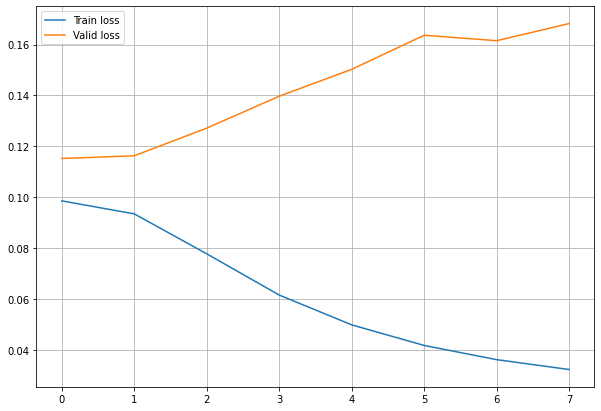

Evaluation: 100%|██████████| 987/987 [00:38<00:00, 25.67it/s]


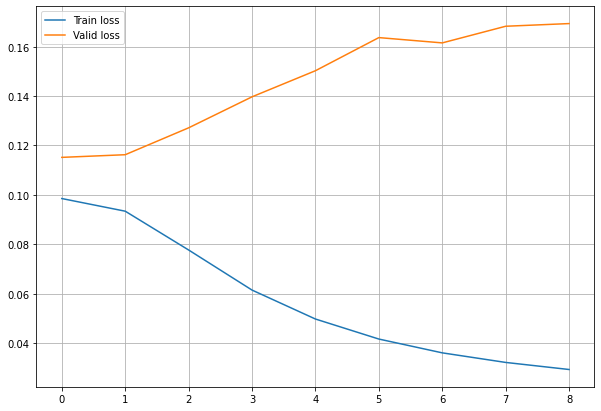

Evaluation: 100%|██████████| 987/987 [00:36<00:00, 27.05it/s]


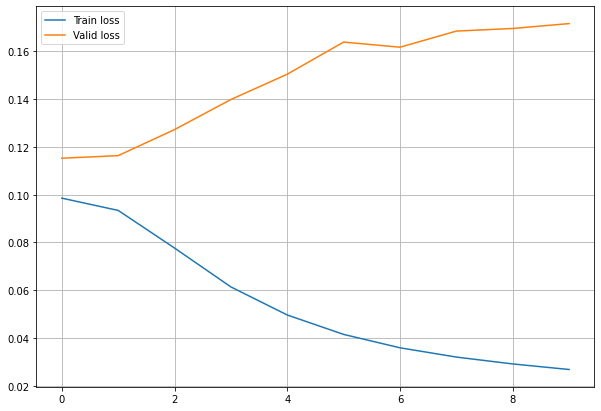

In [ ]:
whole_train_valid_cycle(ncf, 10) # emb 100 + 38 feats  238-64

In [ ]:
evaluate(ncf, dl_val)

Evaluation: 100%|██████████| 987/987 [00:47<00:00, 20.66it/s]


0.1713863804619363

In [ ]:
torch.save(ncf.state_dict(), 'ncf_CC_01_17138.pth')

In [ ]:
ncf.load_state_dict(torch.load('/content/ncf_CC_01_17138.pth'))

<All keys matched successfully>

Evaluation: 100%|██████████| 987/987 [00:36<00:00, 26.80it/s]


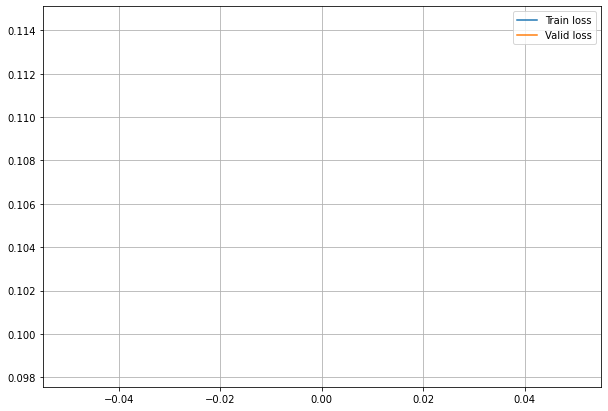

Evaluation: 100%|██████████| 987/987 [00:36<00:00, 27.00it/s]


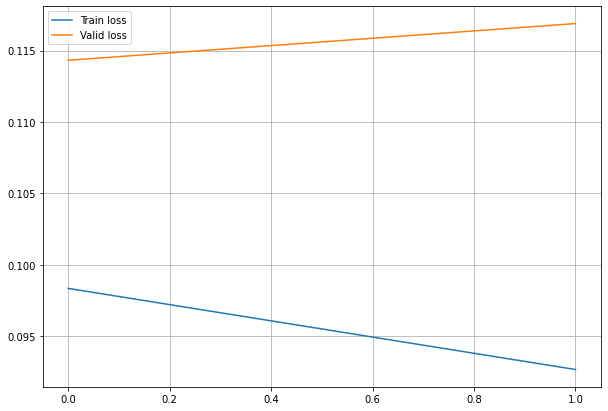

In [ ]:
whole_train_valid_cycle(ncf, 2) # emb 100 + 38 feats  238-64

In [ ]:
evaluate(ncf, dl_val)

Evaluation: 100%|██████████| 987/987 [00:53<00:00, 18.55it/s]


0.11688484951264952

In [ ]:
torch.save(ncf.state_dict(), 'ncf_CC_02_11688.pth')

# Метрики

In [21]:
from sklearn.metrics import roc_auc_score

In [22]:
ds_test.data.head()

,timestamp,user_id,post_id,target,total_tfidf,max_tfidf,mean_tfidf,dist_1_cluster,dist_2_cluster,dist_3_cluster,...,month_12,day_1,day_2,day_3,day_4,day_5,day_6,country,city,hour
0,2021-12-24 13:59:16,200,6450,0,0.342079,0.336207,0.000155,0.443013,0.171766,0.220949,...,1,0,0,0,1,0,0,0.105616,0.151927,0.101607
5,2021-12-29 15:24:31,200,2213,1,0.415431,0.520588,0.000188,0.453078,0.181180,0.277863,...,1,0,1,0,0,0,0,0.105616,0.151927,0.102667
17,2021-12-24 13:54:36,200,5558,0,0.579909,0.225246,0.000262,0.425750,0.083841,0.152464,...,1,0,0,0,1,0,0,0.105616,0.151927,0.101607
48,2021-12-29 08:23:45,201,7159,0,0.320593,0.495164,0.000145,0.420592,0.089518,0.155043,...,1,0,1,0,0,0,0,0.105616,0.134679,0.109906
49,2021-12-29 08:05:14,201,7119,0,0.408379,0.171771,0.000185,0.406667,0.047020,0.173553,...,1,0,1,0,0,0,0,0.105616,0.134679,0.109906


In [35]:
n_users = ds_train.n_users
n_items = ds_train.n_posts
latent_size = 100
feats_size = ds_train[0][2].shape[0]

ncf = NCCF(n_users, n_items, latent_size, feats_size).to(DEVICE)

In [36]:
ncf.load_state_dict(torch.load('ncf_CC_02_11688.pth'))

<All keys matched successfully>

ncf_CC_02_11688.pth

In [37]:
X_train = ds_train.data.copy()

preds = []
for users, items, feats, labels in tqdm(dl_train):
    with torch.no_grad():
        output = ncf(users, items, feats)
    output = torch.sigmoid(output)
    preds.append(output)

preds = torch.cat(preds)
X_train['pred'] = np.array(preds)

100%|████████████████████████████████████████████████████████████████████████████| 26661/26661 [21:00<00:00, 21.16it/s]


In [39]:
X_test = ds_test.data.copy()

preds = []
for users, items, feats, labels in tqdm(dl_test):
    with torch.no_grad():
        output = ncf(users, items, feats)
    output = torch.sigmoid(output)
    preds.append(output)

preds = torch.cat(preds)
X_test['pred'] = preds

100%|██████████████████████████████████████████████████████████████████████████████| 3819/3819 [02:34<00:00, 24.76it/s]


In [47]:
print('Качество на трейне: {:.6f}'.format(roc_auc_score(X_train['target'], X_train['pred'])))
print('Качество на тесте: {:.6f}'.format(roc_auc_score(X_test['target'], X_test['pred'])))

Качество на трейне: 0.500085
Качество на тесте: 0.622823


In [48]:
users_dsgs = []


for user in tqdm(X_test['user_id'].unique()):
    part = X_test[X_test['user_id']==user]
    part = part.sort_values('pred', ascending=False)
    # part = part.reset_index()
    user_dsg2 = (part['target'] / np.log2(part.index+2))[:2].sum()

    users_dsgs.append(user_dsg2)
  
print()
print(f"Среднее DSG@2 по пользователям из теста: {np.mean(users_dsgs)}")

100%|█████████████████████████████████████████████████████████████████████████| 122722/122722 [04:34<00:00, 447.22it/s]


Среднее DSG@2 по пользователям из теста: 0.013962694880513177


In [49]:
users_hit5 = []

for user in tqdm(X_test['user_id'].unique()):
    part = X_test[X_test['user_id']==user]
    part = part.sort_values('pred', ascending=False)
    # part = part.reset_index()
    hit_5 = max(1, sum(part['target'][:5]))
    
    users_hit5.append(hit_5)

print()
print(f"Среднее Hitrate@5 по пользователям из теста: {np.mean(users_hit5)}")

100%|█████████████████████████████████████████████████████████████████████████| 122722/122722 [03:51<00:00, 529.90it/s]


Среднее Hitrate@5 по пользователям из теста: 1.1014569514838415
